<a href="https://colab.research.google.com/github/Lokeshgadhi/introonpandas/blob/main/lokesh_recommendation%20system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anime Recommendation System using Cosine Similarity

In [1]:
!pip install pandas scikit-learn scipy

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

In [3]:
# Load dataset
anime_df = pd.read_csv("anime.csv")
print("Dataset loaded successfully.\n")
print(anime_df.head())

Dataset loaded successfully.

   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  


In [4]:
# Data cleaning
anime_df.dropna(subset=['genre', 'rating'], inplace=True)
anime_df.fillna({'episodes': 0}, inplace=True)
anime_df.drop_duplicates(subset='name', inplace=True)
anime_df.reset_index(drop=True, inplace=True)
print("Data cleaned and ready for feature extraction.")

Data cleaned and ready for feature extraction.


In [5]:
# Feature extraction
tfidf = TfidfVectorizer(stop_words='english')
genre_matrix = tfidf.fit_transform(anime_df['genre'])
scaler = MinMaxScaler()
normalized_ratings = scaler.fit_transform(anime_df[['rating']])
features = hstack([genre_matrix, normalized_ratings])
print("Features combined using genres and ratings.")

Features combined using genres and ratings.


In [6]:
# Cosine similarity matrix
cosine_sim = cosine_similarity(features, features)
print("Cosine similarity matrix computed.")

Cosine similarity matrix computed.


In [7]:
# Recommendation function
def recommend_anime(title, top_n=10, threshold=0.2):
    if title not in anime_df['name'].values:
        return f"Anime '{title}' not found in the dataset."
    idx = anime_df[anime_df['name'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [x for x in sim_scores if x[0] != idx and x[1] >= threshold]
    top_anime = sim_scores[:top_n]
    return [(anime_df.iloc[i]['name'], score) for i, score in top_anime]

In [8]:
# Try a recommendation
print(recommend_anime("Naruto", top_n=5))

[('Naruto: Shippuuden', np.float64(0.9999496292892799)), ('Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi', np.float64(0.9999481049853969)), ('Boruto: Naruto the Movie', np.float64(0.999857229347821)), ('Naruto x UT', np.float64(0.9998356939954685)), ('Naruto: Shippuuden Movie 4 - The Lost Tower', np.float64(0.9997551002626752))]


In [9]:
# Evaluate using Precision@10
train, test = train_test_split(anime_df, test_size=0.2, random_state=42)
def evaluate_precision(test_set):
    hits = 0
    total = 0
    for title in test_set['name'].sample(100, random_state=42):
        recs = recommend_anime(title, top_n=10)
        if isinstance(recs, str):
            continue
        rec_titles = [r[0] for r in recs]
        hits += len(set(rec_titles).intersection(set(test_set['name']))) > 0
        total += 1
    precision = hits / total if total > 0 else 0
    print(f"Precision@10: {precision:.2f}")

evaluate_precision(test)

Precision@10: 0.87


In [10]:
# prompt: explorecosine similarities

# Let's explore some more anime recommendations to see the cosine similarities.

# Recommend anime similar to 'Death Note'
print("\nAnime recommendations for 'Death Note':")
print(recommend_anime("Death Note", top_n=5))

# Recommend anime similar to 'Attack on Titan'
print("\nAnime recommendations for 'Attack on Titan':")
print(recommend_anime("Attack on Titan", top_n=5))

# Recommend anime similar to 'Spirited Away'
print("\nAnime recommendations for 'Spirited Away':")
print(recommend_anime("Spirited Away", top_n=5))

# Recommend anime similar to 'One Punch Man'
print("\nAnime recommendations for 'One Punch Man':")
print(recommend_anime("One Punch Man", top_n=5))

# Adjust the threshold and see how it affects recommendations for 'Naruto'
print("\nAnime recommendations for 'Naruto' with a higher threshold (0.5):")
print(recommend_anime("Naruto", top_n=5, threshold=0.5))

print("\nAnime recommendations for 'Naruto' with a lower threshold (0.1):")
print(recommend_anime("Naruto", top_n=5, threshold=0.1))


Anime recommendations for 'Death Note':
[('Death Note Rewrite', np.float64(0.9979434413410966)), ('Mousou Dairinin', np.float64(0.9774676768411148)), ('Higurashi no Naku Koro ni Kai', np.float64(0.9284157763357779)), ('Higurashi no Naku Koro ni Rei', np.float64(0.9098909013909144)), ('Mirai Nikki (TV)', np.float64(0.8872560603222566))]

Anime recommendations for 'Attack on Titan':
Anime 'Attack on Titan' not found in the dataset.

Anime recommendations for 'Spirited Away':
Anime 'Spirited Away' not found in the dataset.

Anime recommendations for 'One Punch Man':
[('One Punch Man Specials', np.float64(0.9975335382072843)), ('One Punch Man: Road to Hero', np.float64(0.9974789216287816)), ('Tentai Senshi Sunred 2nd Season', np.float64(0.8985723946914664)), ('Tentai Senshi Sunred', np.float64(0.8974464984061024)), ('Tentai Senshi Sunred: Short Corner', np.float64(0.8787361845698709))]

Anime recommendations for 'Naruto' with a higher threshold (0.5):
[('Naruto: Shippuuden', np.float64(0.


--- Exploratory Data Analysis ---

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12015 entries, 0 to 12014
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12015 non-null  int64  
 1   name      12015 non-null  object 
 2   genre     12015 non-null  object 
 3   type      12015 non-null  object 
 4   episodes  11828 non-null  float64
 5   rating    12015 non-null  float64
 6   members   12015 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 657.2+ KB

Descriptive Statistics:
           anime_id      episodes        rating       members
count  12015.000000  11828.000000  12015.000000  1.201500e+04
mean   13635.006742     12.488671      6.478359  1.835192e+04
std    11229.594481     47.100876      1.023806  5.537660e+04
min        1.000000      1.000000      1.670000  1.200000e+01
25%     3390.500000      1.000000      5.890000  2.250000e+02
50%     9958.000000      2.000

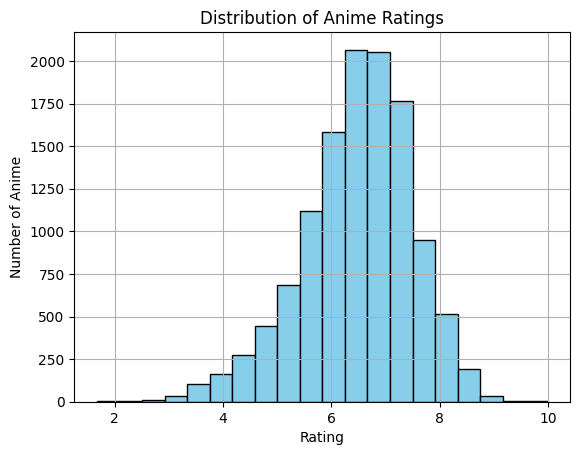


Distribution of 'episodes' (excluding values over 100):


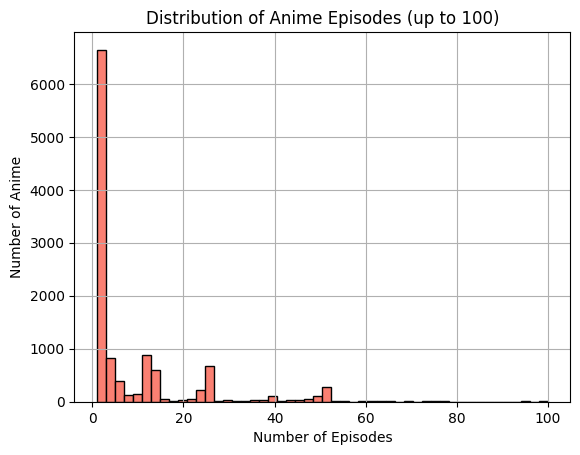


Average rating by anime type:
type
TV         6.903321
Special    6.523126
OVA        6.375411
Movie      6.334431
ONA        5.650293
Music      5.588996
Name: rating, dtype: float64


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'episodes' is numeric
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')

# --- Exploratory Data Analysis (EDA) ---
print("\n--- Exploratory Data Analysis ---")

# 1. Basic dataset info
print("\nDataset Info:")
anime_df.info()

# 2. Descriptive stats
print("\nDescriptive Statistics:")
print(anime_df.describe())

# 3. Anime type distribution
print("\nValue counts for 'type':")
print(anime_df['type'].value_counts())

# 4. Top 10 genres
print("\nTop 10 most frequent genres:")
all_genres = ', '.join(anime_df['genre'].dropna()).split(', ')
genre_counts = pd.Series(all_genres).value_counts()
print(genre_counts.head(10))

# 5. Rating distribution
print("\nDistribution of 'rating':")
anime_df['rating'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Anime Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Anime')
plt.grid(True)
plt.show()

# 6. Episode distribution (limit to <= 100)
print("\nDistribution of 'episodes' (excluding values over 100):")
anime_df[anime_df['episodes'] <= 100]['episodes'].hist(bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Anime Episodes (up to 100)')
plt.xlabel('Number of Episodes')
plt.ylabel('Number of Anime')
plt.grid(True)
plt.show()

# 7. Mean rating by anime type
print("\nAverage rating by anime type:")
print(anime_df.groupby('type')['rating'].mean().sort_values(ascending=False))


In [13]:
# prompt: Explore on collaborative filtering methods like user-based and item-based.

# Collaborative Filtering Methods

# User-Based Collaborative Filtering
# This method finds users who are similar to the target user based on their ratings
# and recommends items that those similar users liked but the target user has not yet seen.

# Item-Based Collaborative Filtering
# This method finds items that are similar to the items that the target user liked
# based on ratings from all users and recommends those similar items.

# For implementing collaborative filtering, we first need user-item interaction data.
# The current dataset 'anime_df' contains anime metadata, but not user ratings for specific anime.
# A separate dataset with user ratings (e.g., user_id, anime_id, rating) is required
# to build a collaborative filtering system.

# Let's assume we have a hypothetical 'ratings_df' dataset with user ratings.
# We will simulate creating a small ratings dataframe for demonstration purposes.

# Create a dummy ratings DataFrame for demonstration
ratings_data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4],
    'anime_id': [20, 24, 50, 20, 70, 24, 70, 11741, 50, 11741, 16498], # Using actual anime_id from the dataset
    'rating': [8, 9, 7, 9, 6, 10, 8, 9, 8, 7, 9]
}
ratings_df = pd.DataFrame(ratings_data)

# Merge with anime data to get anime names
# Ensure anime_id in ratings_df matches 'anime_id' column in anime_df
# Using the correct column name 'anime_id' based on the anime_df structure
ratings_df_merged = pd.merge(ratings_df, anime_df[['anime_id', 'name']], on='anime_id', how='left')

print("\n--- Demonstrating Collaborative Filtering Concept (Requires Rating Data) ---")
print("\nExample User-Item Rating Data:")
print(ratings_df_merged)

# To implement user-based or item-based CF, you typically:
# 1. Create a user-item matrix (or a similar data structure).
# 2. Calculate similarity between users (user-based) or items (item-based).
#    Common similarity metrics include Cosine Similarity or Pearson Correlation.
# 3. Generate recommendations based on similarity and ratings.

# User-Item Matrix
# We'll pivot the ratings data to create a user-item matrix.
# Fill missing values with 0 or a placeholder representing no rating.
user_item_matrix = ratings_df_merged.pivot_table(index='user_id', columns='name', values='rating').fillna(0)

print("\nUser-Item Matrix:")
print(user_item_matrix)

# User-Based Similarity (Example using Cosine Similarity)
# Calculate similarity between users based on their rating patterns
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between rows (users)
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

print("\nUser Similarity Matrix (User-Based CF):")
print(user_similarity_df)

# Example Recommendation for User 1 (User-Based)
# Find users similar to User 1 and recommend items they liked but User 1 didn't rate.
target_user_id = 1
similar_users = user_similarity_df[target_user_id].sort_values(ascending=False)
# Exclude the target user themselves
similar_users = similar_users.drop(target_user_id)

print(f"\nUsers similar to User {target_user_id}:")
print(similar_users)

# To get recommendations, we would look at the ratings of these similar users
# for items not rated by the target user and predict a rating or recommend the highest-rated items.
# This requires more extensive rating data to be meaningful.

# Item-Based Similarity (Example using Cosine Similarity)
# Calculate similarity between items based on how users rated them
# Calculate cosine similarity between columns (items)
item_similarity = cosine_similarity(user_item_matrix.T) # Transpose the matrix to calculate similarity between columns
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

print("\nItem Similarity Matrix (Item-Based CF):")
print(item_similarity_df)

# Example Recommendation based on an item liked by User 1 (Item-Based)
# Suppose User 1 liked 'Naruto'. Find items similar to 'Naruto' that User 1 hasn't seen.
liked_item = 'Naruto'
if liked_item in item_similarity_df.index:
    similar_items = item_similarity_df[liked_item].sort_values(ascending=False)
    # Exclude the item itself
    similar_items = similar_items.drop(liked_item)

    print(f"\nItems similar to '{liked_item}' (Item-Based CF):")
    print(similar_items)
else:
    print(f"\nItem '{liked_item}' not found in the dummy ratings data for Item-Based CF.")

# Key Differences:
# User-Based: "Users who liked this item also liked..." (Similarity based on user rating patterns)
# Item-Based: "Users who liked this item also liked this other item..." (Similarity based on how users rated items)

# Advantages & Disadvantages:
# User-Based:
# + Good at discovering new, unexpected items (serendipity).
# - Suffers from the "cold-start problem" for new users.
# - Performance can degrade with a large number of users.
# - Scalability issues for large datasets.

# Item-Based:
# + Generally scales better with the number of users than user-based.
# + Recommendations are more stable as item similarity changes slower than user preferences.
# - Suffers from the "cold-start problem" for new items.
# - May recommend items too similar to what the user already liked (less serendipity).

# In practice, implementing a full collaborative filtering system involves:
# - Handling sparse matrices efficiently.
# - Developing strategies for cold-start users and items.
# - Using more sophisticated prediction or ranking algorithms.
# - Evaluating recommendations using metrics like Precision, Recall, F1-score, RMSE, etc.

# The current content-based recommendation system using cosine similarity on genre and rating
# is a good starting point, but collaborative filtering provides a different perspective
# by leveraging user interaction data.



--- Demonstrating Collaborative Filtering Concept (Requires Rating Data) ---

Example User-Item Rating Data:
    user_id  anime_id  rating                   name
0         1        20       8                 Naruto
1         1        24       9          School Rumble
2         1        50       7  Aa! Megami-sama! (TV)
3         2        20       9                 Naruto
4         2        70       6                    NaN
5         3        24      10          School Rumble
6         3        70       8                    NaN
7         3     11741       9   Fate/Zero 2nd Season
8         4        50       8  Aa! Megami-sama! (TV)
9         4     11741       7   Fate/Zero 2nd Season
10        4     16498       9     Shingeki no Kyojin

User-Item Matrix:
name     Aa! Megami-sama! (TV)  Fate/Zero 2nd Season  Naruto  School Rumble  \
user_id                                                                       
1                          7.0                   0.0     8.0            9.0  

1. Can you explain the difference between user-based and item-based collaborative filtering?

---

### 1. **User-Based Collaborative Filtering (UBCF)**

* **Idea**: Recommend items to a user based on what **similar users** liked.

* **How it works**:

  * Find users with similar preferences (based on rating history).
  * Recommend items that those similar users liked, which the current user hasn't seen yet.

* **Example**:
  If Alice and Bob both liked the same 3 anime, and Bob also liked a 4th anime, recommend that 4th anime to Alice.

* **Similarity Computed Between**: **Users**

* **Common Similarity Metrics**: Cosine similarity, Pearson correlation

#### Pros:

* Captures social-like behavior (“people like you liked this”)

#### Cons:

* Can be slow or sparse with many users
* Performance drops with new users (cold start)

---

###  2. **Item-Based Collaborative Filtering (IBCF)**

* **Idea**: Recommend items **similar to the ones a user already liked**.

* **How it works**:

  * For each item the user likes, find similar items (based on how other users rated them).
  * Recommend those similar items.

* **Similarity Computed Between**: **Items**

* **Common Similarity Metrics**: Cosine similarity, adjusted cosine similarity

#### Pros:

* Scales better with large user bases
* More stable over time (items change less frequently than users)

#### Cons:

* May miss out on social signals (e.g., “users like you liked...”)

---

### Summary Table:

| Feature                 | User-Based CF              | Item-Based CF               |
| ----------------------- | -------------------------- | --------------------------- |
| Similarity Between      | Users                      | Items                       |
| Recommendation Based On | Similar users’ preferences | Similar items to liked ones |
| Better For              | Small user bases           | Large, stable item sets     |
| Cold Start Issue        | New users                  | New items                   |
| Performance             | Can be slower              | Often faster                |




2. What is collaborative filtering, and how does it work?

**Collaborative Filtering** is a popular technique used in recommendation systems to suggest items (like movies, books, or anime) based on **user preferences and behavior** rather than item content.

---

###  What Is Collaborative Filtering?

It is a method that makes automatic predictions about a user's interests by collecting preferences or taste information from **many users** (collaboration).

---

###  Core Idea

> "If User A and User B liked similar items in the past, and User A likes a new item, then User B might like it too."

---

###  How It Works

Collaborative filtering operates using a **user-item interaction matrix**, where rows represent users, columns represent items, and cells contain ratings (explicit) or interactions (implicit like clicks, views).

#### Two Main Types:

---

#### 1. **User-Based Collaborative Filtering**

* Compares users to find similar ones.
* Recommends items liked by similar users.

#### 2. **Item-Based Collaborative Filtering**

* Compares items to find similar ones.
* Recommends items similar to what the user has already liked.

---

### Example Matrix:

|        | Anime A | Anime B | Anime C | Anime D |
| ------ | ------- | ------- | ------- | ------- |
| User 1 | 5       | 4       | ?       | 3       |
| User 2 | 5       | 4       | 2       | 3       |
| User 3 | 1       | 2       | 5       | ?       |

* Collaborative filtering will predict `User 1's` rating for **Anime C** based on similar users (like User 2) or similar items.

---

###  Key Techniques:

* **Similarity Calculation**: Cosine similarity, Pearson correlation
* **Matrix Factorization**: Advanced methods like SVD, ALS
* **Deep Learning**: Neural Collaborative Filtering (NCF)

---

###  Pros:

* No need for item metadata or content
* Can discover complex patterns and relationships

### Cons:

* **Cold Start**: Struggles with new users/items (no data)
* **Sparsity**: Most users rate only a few items
* **Scalability**: Can be slow for very large datasets
